# PPCA
This is my PPCA model. It is based on the original model as proposed by Tipping & Bishop (1999). This notebook will start with the closed-form solution and then continue with the iterative EM-algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
N=5000
M=2
D=3

We specify a latent dataset $\textbf{z}$ as given by a zero-mean unit-covariance Gaussian $p(\textbf{z})=\mathcal{N}(\textbf{z}|\textbf{0},\textbf{I})$. The observed variable $\textbf{x}$ given $\textbf{z}$ has the form $p(\textbf{x}|\textbf{z})=\mathcal{N}(\textbf{x}|\textbf{Wz}+\mathcal{N}(\textbf{z}|\mu, \sigma^2 \textbf{I})$.

In [3]:
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
print('mu: ', mu)
print('sigma: ', sigma)
print('W: ', W)

mu:  [[-4.09393864]
 [ 1.72485428]
 [ 4.35914732]]
sigma:  0.5021617581572246
W:  [[ 0.39409842 -0.82018838]
 [ 1.06617175  0.86316935]
 [ 0.51482428  1.03577203]]


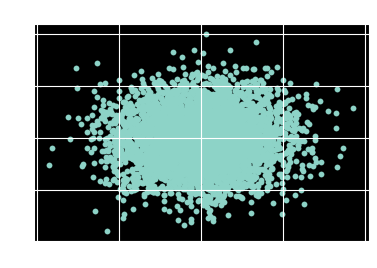

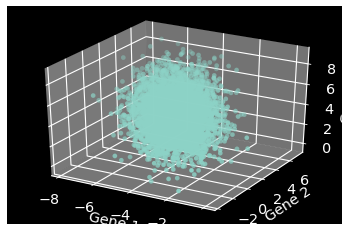

In [4]:
plt.figure()
plt.scatter(z[0,:], z[1,:])
plt.title('latent data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:])
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

## Closed form solution

$\mu_{ML}$ is given by the mean of the data.

In [5]:
mu_ML = np.mean(x,axis=1)[np.newaxis].T
print('mu:\n', mu)
print('mu_ML:\n', mu_ML)

mu:
 [[-4.09393864]
 [ 1.72485428]
 [ 4.35914732]]
mu_ML:
 [[-4.06429632]
 [ 1.69473055]
 [ 4.33314898]]


$\sigma^2_{ML}$ is given by $\sigma^2_{ML} = \frac{1}{D-M}\sum^D_{i=M+1}\lambda_i$, where $\lambda_i$ are the eigenvalues of the covariance matrix $\textbf{S} = \frac{1}{N}\sum_{n=1}^{N}(\textbf{x}_n-\bar{\textbf{x}})(\textbf{x}_n-\bar{\textbf{x}})^T$. This sets $\sigma^2_{ML}$ to the average variance of the lost dimensions.

In [6]:
S = np.cov(x)

# Or
# S = np.outer((x[:,0]-np.mean(x,axis=1)),(x[:,0]-np.mean(x,axis=1)))
# for n in range(1,N):
#     S += np.outer((x[:,n]-np.mean(x,axis=1)),(x[:,n]-np.mean(x,axis=1)))
# S = S/N

eigenvalues, eigenvectors = np.linalg.eig(S)

# We wish to use the largest eigenvalues, so we sort the eigenvalues and their corresponsing eigenvectors
order = np.argsort(eigenvalues)[::-1]
eigenvalues = np.sort(eigenvalues)[::-1]
eigenvectors = eigenvectors[order]

sigma_ML = 0.0
for i in range(M,D):
    sigma_ML += eigenvalues[i]
sigma_ML = sigma_ML/(D-M)

$\textbf{W}_{ML}$ can be found as $\textbf{W}_{ML} = \textbf{U}_M(\textbf{L}_M - \sigma^2\textbf{I})^{\frac{1}{2}}\textbf{R}$ where

the columns of $\textbf{U}$ are a (any) subset of $\textbf{M}$ eigenvectors of the data covariance matrix $\textbf{S}$,

$\textbf{L}_M$ is a diagonal matrix containing the corresponding eigenvalues $\lambda_i$ and

$\textbf{R}$ is an arbitrary rotation matrix (in this case, $R=I_M$).

In [7]:
U = eigenvectors[:M].T
L = np.diag(eigenvalues[:M])
R = np.eye(M)
W_ML = np.matmul(np.matmul(U,np.sqrt((L-sigma_ML*np.eye(M)))),R)

In [8]:
x_sim_closed = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

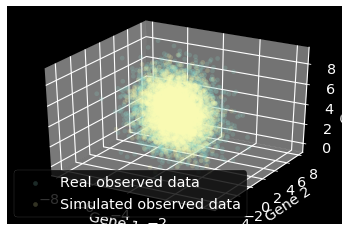

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2, label='Real observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [10]:
mu_ML_closed = mu_ML.copy()
sigma_ML_closed = sigma_ML.copy()
W_ML_closed = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML)
print()
print('W: ', W)
print('W_ML: ', W_ML)

mu:  [[-4.09393864]
 [ 1.72485428]
 [ 4.35914732]]
mu_ML:  [[-4.06429632]
 [ 1.69473055]
 [ 4.33314898]]

sigma:  0.5021617581572246
sigma_ML:  0.25293589010241296

W:  [[ 0.39409842 -0.82018838]
 [ 1.06617175  0.86316935]
 [ 0.51482428  1.03577203]]
W_ML:  [[-0.46221958  0.6385496 ]
 [ 1.58756436  0.40490928]
 [ 0.76319044 -0.4555474 ]]


## EM-algorithm for PPCA

In [27]:
# initialization
mu_ML = np.mean(x,axis=1)[np.newaxis].T
sigma_ML = 1
W_ML = np.ones((D,M))
sigma_ML_2 = 1
W_ML_2 = W_ML.copy()
sigma_ML_3 = 1
W_ML_3 = W_ML.copy()

In [28]:
iterations = 50
calculate_loglikelihood = True

log_likes = []
sigmas = [sigma_ML]
Ws = [W_ML]

for iteration in range(iterations):
    if calculate_loglikelihood == True:
        # E-step
        inv_mat = np.linalg.inv(sigma_ML*np.eye(M)+np.matmul(W_ML.T,W_ML))
        E_z = np.matmul(np.matmul(inv_mat,W_ML.T),(x-mu))
        E_zzT = sigma_ML*inv_mat+np.matmul(E_z,E_z.T)

        sums = 0
        for n in range(N):
            sums += -0.5*np.trace(E_zzT)
            sums -= np.trace(np.matmul((x-mu),(x-mu).T)-2*np.matmul(np.matmul((x-mu),E_z.T),W_ML.T)+np.matmul(np.matmul(W,E_zzT),W_ML.T))/(2*sigma_ML)

        Log_likelihood = -0.5*D*np.log(sigma_ML) - sums
        log_likes.append(Log_likelihood)
    
    
    # M-step
    S = np.cov(x)
    M_mat = sigma_ML*np.eye(M) + np.matmul(W_ML.T,W_ML)   # note that M_mat refers to a matrix and M to the number of latent dimensions

    W_ML_new = np.matmul(np.matmul(S,W_ML),np.linalg.inv(sigma_ML*np.eye(M)+np.matmul(np.matmul(np.matmul(np.linalg.inv(M_mat),W_ML.T),S),W_ML)))
    sigma_ML = np.trace(S-np.matmul(np.matmul(np.matmul(S,W_ML),np.linalg.inv(M_mat)),W_ML_new.T))/D
    
    W_ML = W_ML_new.copy()
    
    sigmas.append(sigma_ML)
    Ws.append(W_ML)
    

In [17]:
x_sim_em = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

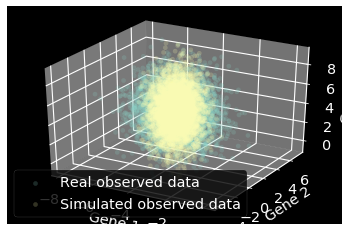

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2, label='Real observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [19]:
mu_ML_em = mu_ML.copy()
sigma_ML_em = sigma_ML.copy()
W_ML_em = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_em)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML_em)
print()
print('W: ', W)
print('W_ML: ', W_ML_em)

mu:  [[-4.09393864]
 [ 1.72485428]
 [ 4.35914732]]
mu_ML:  [[-4.06429632]
 [ 1.69473055]
 [ 4.33314898]]

sigma:  0.5021617581572246
sigma_ML:  0.6425461661924934

W:  [[ 0.39409842 -0.82018838]
 [ 1.06617175  0.86316935]
 [ 0.51482428  1.03577203]]
W_ML:  [[-0.30704072 -0.30704109]
 [ 0.875085    0.8750848 ]
 [ 0.77677586  0.77677593]]


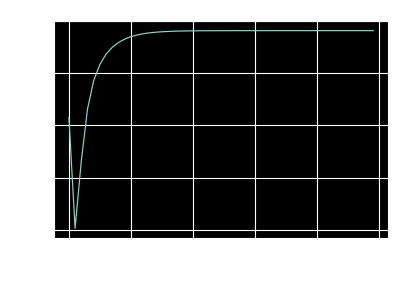

In [20]:
plt.plot(range(len(log_likes)), log_likes)
plt.ylabel('log-likelihood')
plt.xlabel('iteration')
plt.show()

## Evaluation

In [21]:
print('mu (real value):\n', mu)
print('mu_ML (closed form solution):\n', mu_ML_closed)
print('mu_ML (EM solution):\n', mu_ML_em)
print()
print('sigma (real value):\n', sigma)
print('sigma_ML (closed form solution):\n: ', sigma_ML_closed)
print('sigma_ML (EM solution):\n: ', sigma_ML_em)
print()
print('W (real value): ', W)
print('W_ML (closed form solution):\n: ', W_ML_closed)
print('W_ML (EM solution):\n: ', W_ML_em)

mu (real value):
 [[-4.09393864]
 [ 1.72485428]
 [ 4.35914732]]
mu_ML (closed form solution):
 [[-4.06429632]
 [ 1.69473055]
 [ 4.33314898]]
mu_ML (EM solution):
 [[-4.06429632]
 [ 1.69473055]
 [ 4.33314898]]

sigma (real value):
 0.5021617581572246
sigma_ML (closed form solution):
:  0.25293589010241296
sigma_ML (EM solution):
:  0.6425461661924934

W (real value):  [[ 0.39409842 -0.82018838]
 [ 1.06617175  0.86316935]
 [ 0.51482428  1.03577203]]
W_ML (closed form solution):
:  [[-0.46221958  0.6385496 ]
 [ 1.58756436  0.40490928]
 [ 0.76319044 -0.4555474 ]]
W_ML (EM solution):
:  [[-0.30704072 -0.30704109]
 [ 0.875085    0.8750848 ]
 [ 0.77677586  0.77677593]]


Neither of the solutions manages to find accurate estimates of $\sigma$ or $W$.

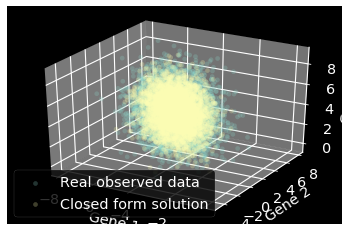

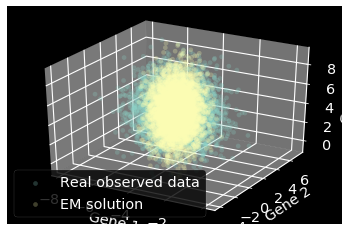

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.25, label='Real observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.25, label='Closed form solution')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.25, label='Real observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.25, label='EM solution')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

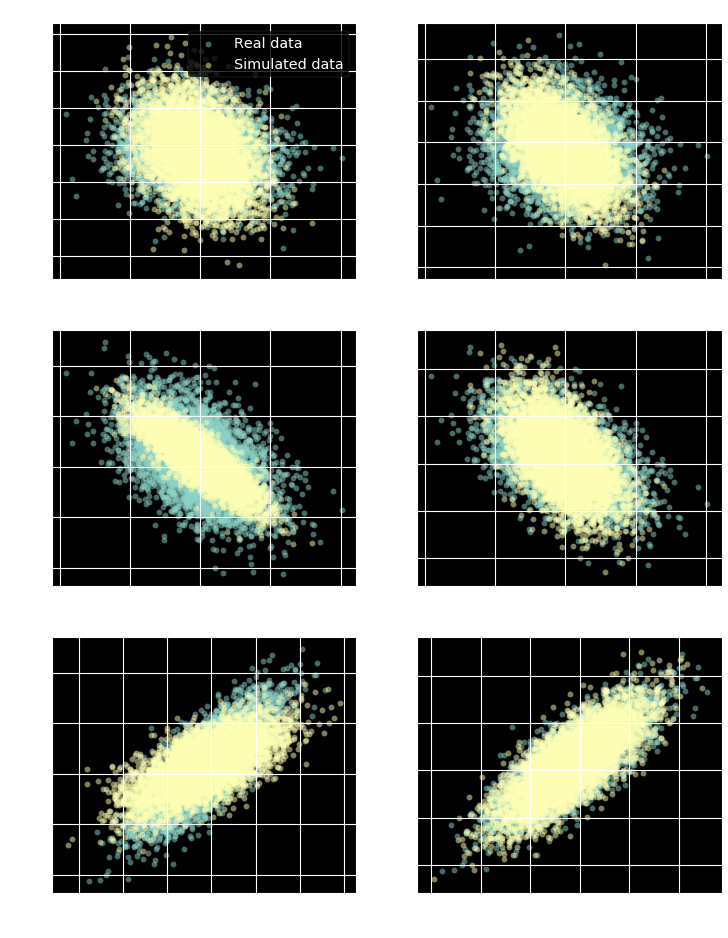

In [23]:
fig = plt.figure(figsize=(12,16))

plt.subplot(321)
plt.title('Closed-form solution')
plt.scatter(x[0,:],x[1,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_closed[0,:],x_sim_closed[1,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 1')
plt.ylabel('gene 2')
plt.legend()

plt.subplot(322)
plt.title('EM solution')
plt.scatter(x[0,:],x[1,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_em[0,:],x_sim_em[1,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 1')
plt.ylabel('gene 2')

plt.subplot(323)
plt.scatter(x[0,:],x[2,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_closed[0,:],x_sim_closed[2,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 1')
plt.ylabel('gene 3')

plt.subplot(324)
plt.scatter(x[0,:],x[2,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_em[0,:],x_sim_em[2,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 1')
plt.ylabel('gene 3')


plt.subplot(325)
plt.scatter(x[1,:],x[2,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 2')
plt.ylabel('gene 3')

plt.subplot(326)
plt.scatter(x[1,:],x[2,:], alpha=0.5, label='Real data')
plt.scatter(x_sim_em[1,:],x_sim_em[2,:], alpha=0.5, label='Simulated data')
plt.xlabel('gene 2')
plt.ylabel('gene 3')
plt.show()

The EM-algorithm creates more accurate projections of the observed data given the actual latent data than the closed-form solution. All found matrices of $W$ do have the same shape, but the eigenvectors of the innerproduct of the $W$'s with itself are not equal.

In [24]:
print('Angle between two vectors:')
print(np.dot(W[0],W[1])/(np.linalg.norm(W[0],2)*np.linalg.norm(W[1],2)))
print(np.dot(W_ML_closed[0],W_ML_closed[1])/(np.linalg.norm(W_ML_closed[0],2)*np.linalg.norm(W_ML_closed[1],2)))
print(np.dot(W_ML_em[0],W_ML_em[1])/(np.linalg.norm(W_ML_em[0],2)*np.linalg.norm(W_ML_em[1],2)))
print()

print('Eigenvalues and vectors of inner product:')
print(np.linalg.eig(np.matmul(W.T,W)))
print(np.linalg.eig(np.matmul(W_ML_closed.T,W_ML_closed)))
print(np.linalg.eig(np.matmul(W_ML_em.T,W_ML_em)))

Angle between two vectors:
-0.2305483598571832
-0.3679776050889356
-0.9999999999997471

Eigenvalues and vectors of inner product:
(array([0.80096196, 3.24671185]), array([[-0.83117036, -0.55601784],
       [ 0.55601784, -0.83117036]]))
(array([3.3164672 , 0.77922056]), array([[ 1.00000000e+00, -2.49837991e-17],
       [ 0.00000000e+00,  1.00000000e+00]]))
(array([8.97060204e-14, 2.92685699e+00]), array([[-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]]))
